In [10]:
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import mesh, fem
from dolfinx.fem.petsc import assemble_matrix, assemble_vector, apply_lifting, create_vector, set_bc
import numpy as np
from petsc4py.PETSc import ScalarType  # type: ignore
t = 0  # Start time
T = 0.5  # End time
num_steps = 100  # Number of time steps
dt = (T - t) / num_steps  # Time step size
h = 0.01
R = np.pi
nx, ny = int(R/h), int(R/h)
domain = mesh.create_rectangle(comm=MPI.COMM_WORLD,
                            points=((0, 0), (R, R)), n=(nx, ny),
                            cell_type=mesh.CellType.triangle)
V = fem.FunctionSpace(domain, ("Lagrange", 1))

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)
dofs = fem.locate_dofs_topological(V, entity_dim=1, entities=boundary_facets)
bc = fem.dirichletbc(value=ScalarType(0), dofs=dofs, V=V)

In [11]:
class exact_solution():
    def __init__(self,t):
        self.t = t
    def __call__(self, x):
        return np.exp(-2*self.t)*np.sin(x[0])*np.sin(x[1])
u_init = exact_solution(t = t)
u_n = fem.Function(V)
u_n.interpolate(u_init)

class ax():
    def __init__(self):
        pass
    def __call__(self, x):
        return -1.0 + x[0]*0.0
a_fun = ax()
a = fem.Function(V)
a.interpolate(a_fun)

class fx():
    def __init__(self):
        pass
    def __call__(self, x):
        return 1.0 +x[0]*0.0, 1.0 +x[0]*0.0
f_fun = fx()
v_2 = ufl.VectorElement("Lagrange", domain.ufl_cell(), 2)
V_2 = fem.FunctionSpace(domain, v_2)
f = fem.Function(V_2)
f.interpolate(f_fun)

class gx():
    def __init__(self,t):
        self.t = t
    def __call__(self, x):
        return np.exp(-2*self.t)*np.cos(x[0])*np.sin(x[1])+np.exp(-2*self.t)*np.sin(x[0])*np.cos(x[1])
g_fun = gx(t=t)
g = fem.Function(V)
g.interpolate(g_fun)



In [12]:
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
F = u * v * ufl.dx + 1/2*dt * ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx + dt* ufl.dot(f,ufl.grad(u))*v* ufl.dx - dt*a*u*v*ufl.dx - u_n * v * ufl.dx - dt* g*v*ufl.dx
lhs = fem.form(ufl.lhs(F))
rhs = fem.form(ufl.rhs(F))
A = assemble_matrix(lhs, bcs=[bc])
A.assemble()
b = create_vector(rhs)

In [13]:
solver = PETSc.KSP().create(domain.comm)
solver.setOperators(A)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)


In [14]:
uh = fem.Function(V)
for n in range(num_steps):
    # Update Diriclet boundary condition
    # Update the right hand side reusing the initial vector
    g_fun.t += dt
    g.interpolate(g_fun)
    with b.localForm() as loc_b:
        loc_b.set(0)
    assemble_vector(b, rhs)

    # Apply Dirichlet boundary condition to the vector
    apply_lifting(b, [lhs], [[bc]])
    b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
    set_bc(b, [bc])

    # Solve linear problem
    solver.solve(b, uh.vector)
    uh.x.scatter_forward()

    # Update solution at previous time step (u_n)
    u_n.x.array[:] = uh.x.array


In [15]:
# Compute L2 error and error at nodes
class exact_solution():
    def __init__(self,t):
        self.t = t
    def __call__(self, x):
        return np.exp(-2*self.t)*np.sin(x[0])*np.sin(x[1])
u_exact = exact_solution(t =T)
V_ex = fem.FunctionSpace(domain, ("Lagrange", 1))
u_ex = fem.Function(V_ex)
u_ex.interpolate(u_exact)


error_L2 = np.sqrt(domain.comm.allreduce(fem.assemble_scalar(fem.form((uh - u_ex)**2 * ufl.dx)), op=MPI.SUM))
if domain.comm.rank == 0:
    print(f"L2-error: {error_L2:.2e}")

# Compute values at mesh vertices
error_max = domain.comm.allreduce(np.max(np.abs(uh.x.array - u_ex.x.array)), op=MPI.MAX)
if domain.comm.rank == 0:
    print(f"Error_max: {error_max:.2e}")

L2-error: 2.79e-03
Error_max: 1.79e-03


In [16]:
from dolfinx import io, plot
with io.XDMFFile(domain.comm, "out_poisson/poisson.xdmf", "w") as file:
    file.write_mesh(domain)
    file.write_function(uh)


No module named 'trame'

Falling back to a static output.
  warnings.warn(



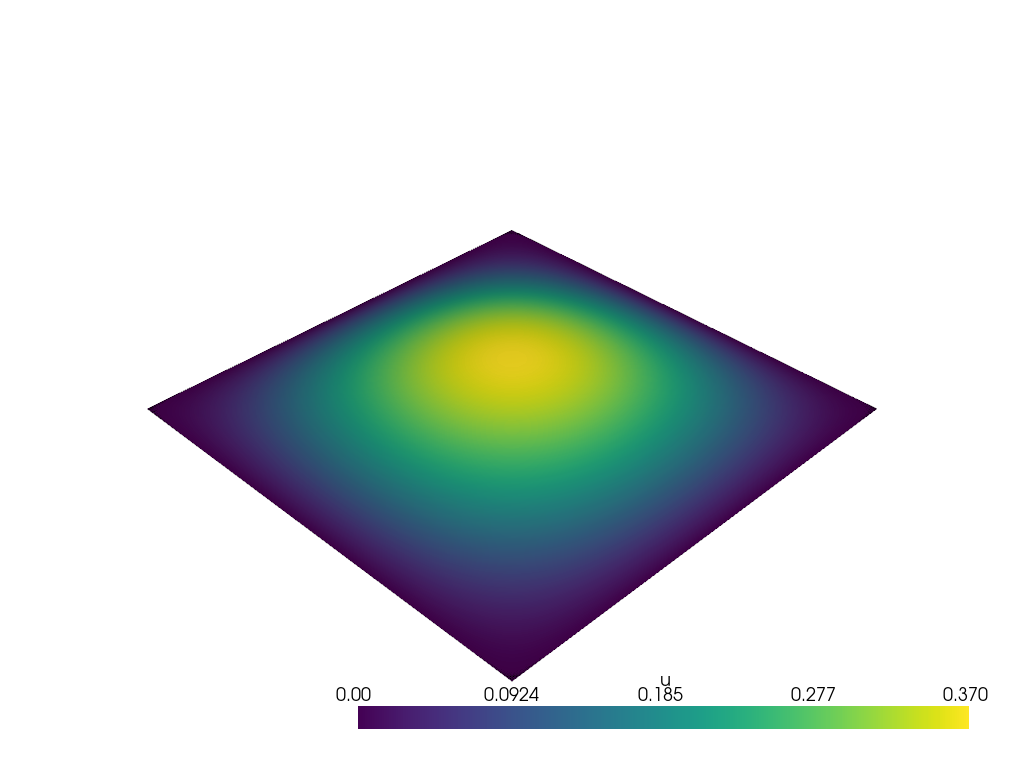

In [17]:
try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = uh.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")


No module named 'trame'

Falling back to a static output.
  warnings.warn(



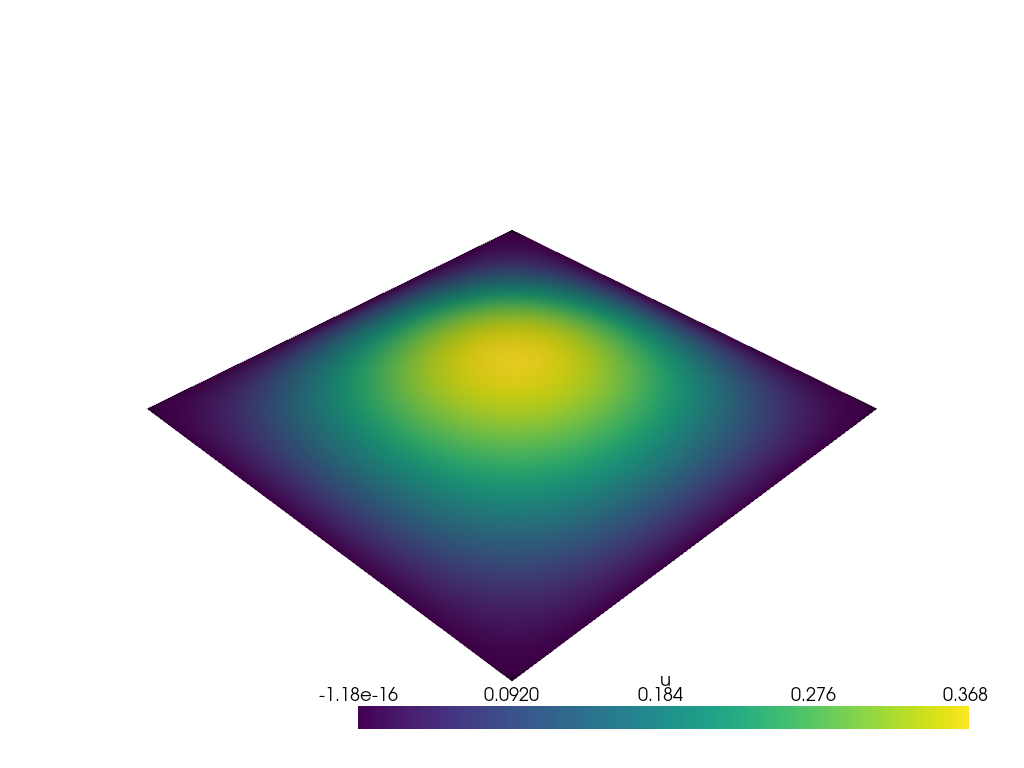

In [18]:

try:
    import pyvista
    cells, types, x = plot.vtk_mesh(V)
    grid = pyvista.UnstructuredGrid(cells, types, x)
    grid.point_data["u"] = u_ex.x.array.real
    grid.set_active_scalars("u")
    plotter = pyvista.Plotter()
    plotter.add_mesh(grid, show_edges=True)
    warped = grid.warp_by_scalar()
    plotter.add_mesh(warped)
    if pyvista.OFF_SCREEN:
        pyvista.start_xvfb(wait=0.1)
        plotter.screenshot("uh_poisson.png")
    else:
        plotter.show()
except ModuleNotFoundError:
    print("'pyvista' is required to visualise the solution")
    print("Install 'pyvista' with pip: 'python3 -m pip install pyvista'")